# Day and Night Image Classifier
---

The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of each example: 100 day images and 100 night images.

We're trying to build a classifier that can accurately label these images as day or night, and that relies on finding distinguishing features between the two types of images!

*Note: All images come from the [AMOS dataset](http://cs.uky.edu/~jacobs/datasets/amos/) (Archive of Many Outdoor Scenes).*


### Import resources

Before we get started on the project code, import the libraries that we'll need.

In [14]:
import os
import glob #for loading images from a directory
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

In [2]:
# Image data directories
image_dir_training = "images/training/"
image_dir_test = "images/test/"

## Step 1: Load the datasets and visualize

These first few lines of code will load the training day/night images and store all of them in a variable, `IMAGE_LIST`. This list contains the images and their associated label ("day" or "night"). 

For example, the first image-label pair in `IMAGE_LIST` can be accessed by index: 
``` IMAGE_LIST[0][:]```.


In [3]:
def load_dataset(image_dir):
    '''This function loads in images and their labels and places them in a list
    im_list[0][:] will be the first image-label pair in the list'''
    
    im_list = []
    image_types = ["day", "night"]
    
    # Iterate through each color folder
    for im_type in image_types:
        
        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")):
            
            # Read in the image
            im = mpimg.imread(file)
            
            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type (red, green, yellow) to the image list
                im_list.append((im, im_type))
    
    return im_list

In [4]:
# Load training data
IMAGE_LIST = load_dataset(image_dir_training)


## Step 2: Preprocess the data input images.

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and numerical labels.
1. Resizing every image to a standard size
2. Encode the target variables

In [5]:
def standardize_input(image):
    
    # Resize image and pre-process so that all "standard" images are the same size
    standard_im = cv2.resize(image, (1100, 600))
    
    return standard_im

In [6]:
def encode(label):
    # encode day as 1, night as 0
    numerical_val = 0
    if(label == 'day'):
        numerical_val = 1
    
    return numerical_val

In [7]:
def preprocess(image_list):
    
    #standardize and encode the input data
    standard_list = []
    
    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]
        
        # Standardize the image
        standardized_im = standardize_input(image)
        
        # Create a numerical label
        binary_label = encode(label)
        
        # Append the image, and it's one hot encoded label to the full, processed list of image data
        standard_list.append((standardized_im, binary_label))
    
    return standard_list

In [8]:
# Standardize all training images
STANDARDIZED_LIST = preprocess(IMAGE_LIST)

Shape: (600, 1100, 3)
Label [1 = day, 0 = night]: 1


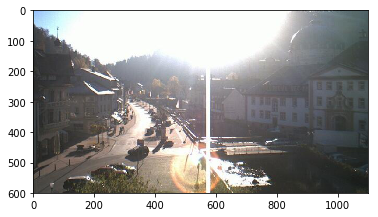

In [11]:
# Display a standardized image and its label

# Select an image by index
image_num = 0
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print("Label [1 = day, 0 = night]: " + str(selected_label))


## Step 3: Feature Extraction

Let's try to create a feature that represents the brightness in an image. We'll be extracting the **average brightness** using HSV colorspace. Specifically, we'll use the V channel (a measure of brightness), add up the pixel values in the V channel, then divide that sum by the area of the image to get the average Value of the image.


In [12]:
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])
    area = 600*1100.0  # pixels
    
    # find the avg
    avg = sum_brightness/area
    
    return avg

Avg brightness: 102.3587696969697


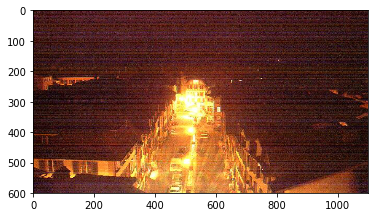

In [15]:
# Testing average brightness levels
# Look at a number of different day and night images and think about 
# what average brightness value separates the two types of images

# As an example, a "night" image is loaded in and its avg brightness is displayed
image_num = 190
test_im = STANDARDIZED_LIST[image_num][0]

avg = avg_brightness(test_im)
print('Avg brightness: ' + str(avg))
plt.imshow(test_im)

## Step 4: Build the classifier

We'll turn our average brightness feature into a classifier that takes in a standardized image and returns a `predicted_label` for that image. This `estimate_label` function should return a value: 0 or 1 (night or day, respectively).

In [20]:
# This function should take in RGB image input
def estimate_label(rgb_image, threshold):
    
    # Extract average brightness feature from an RGB image 
    avg = avg_brightness(rgb_image)
        
    # Use the avg brightness feature to predict a label (0, 1)
    predicted_label = 0
    #threshold = 120
    if(avg > threshold):
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1
    # else, the pred-cted_label can stay 0 (it is predicted to be "night")
    
    return predicted_label    
    

## Step 5: Evaluate the Classifier and Optimize

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook!
Below, we load in the test dataset, standardize it using the `standardize` function you defined above, and then **shuffle** it; this ensures that order will not play a role in testing accuracy.


In [21]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = load_dataset(image_dir_test)

# Standardize the test data
STANDARDIZED_TEST_LIST = preprocess(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

In [22]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images, threshold):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im, threshold)

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels

In [26]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST, threshold=99)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.9375
Number of misclassified images = 10 out of 160
